In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split

import tensorflow as tf
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.optimizers import SGD,RMSprop,adam
from keras.utils import to_categorical
from keras.models import model_from_json
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

Using TensorFlow backend.


In [2]:
# Loading data
data = np.genfromtxt('train.csv', delimiter=',')
data = data[1:]

In [3]:
# sorting data in Y and X
Y = data[0: ,0]
X = data[0: ,1: ]
print(Y.shape, X.shape)

(42000,) (42000, 784)


In [4]:
# Define image dimensions
img_rows = 28
img_cols = 28
channel = 1

# Define model parameters
nb_classes = 10

#batch_size to train
batch_size = 256

# number of output classes
nb_classes = 10

# number of epochs to train
nb_epoch = 150

# number of convolutional filters to use
nb_filters_1 = 20
nb_filters_2 = 50

# size of pooling area for max pooling
nb_pool = 2

# convolution kernel size
nb_conv = 3

In [5]:
# Train-test split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state = 4)

In [6]:
# Using correct dimesntions for input data
X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)

# Assigning X_train and X_test as float
X_train = X_train.astype('float32') 
X_test = X_test.astype('float32')

X_train /= 255
X_test /= 255

# Convert class vectors to binary class matrices
Y_train = to_categorical(Y_train, nb_classes)
Y_test = to_categorical(Y_test, nb_classes)

print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)

(33600, 28, 28, 1) (33600, 10) (8400, 28, 28, 1) (8400, 10)


In [14]:
# Implementing CNN
model = Sequential()

model.add(Conv2D(nb_filters_1, kernel_size = (nb_conv, nb_conv), activation='relu', input_shape=(img_rows, img_cols, 1)))
model.add(MaxPooling2D(pool_size = (nb_pool, nb_pool), strides = (2, 2)))

model.add(Dropout(0.2))

model.add(Conv2D(nb_filters_2, kernel_size = (nb_conv, nb_conv), activation='relu'))
model.add(MaxPooling2D(pool_size = (nb_pool, nb_pool), strides = (2, 2)))

model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(256, activation='relu'))

model.add(Dense(nb_classes, activation='softmax'))

In [15]:
# Optimizer used is Stochastic Gradient Descent with learning rate of 0.01
# Loss is calculated using categorical cross entropy
opt = SGD(lr = 0.01)
ReducedLR = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1, mode='auto', min_lr=1*10**-7)
early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto')
model.compile(loss='categorical_crossentropy', optimizer = opt, metrics = ['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 24, 24, 20)        520       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 12, 12, 20)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 12, 12, 20)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 8, 8, 50)          25050     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 4, 4, 50)          0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 4, 4, 50)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 800)               0         
__________

In [16]:
hist = model.fit(X_train, Y_train, batch_size = batch_size, epochs = nb_epoch, verbose = 1, validation_split = 0.2, shuffle = True, callbacks = [ReducedLR, early_stop])

Instructions for updating:
Use tf.cast instead.
Train on 26880 samples, validate on 6720 samples
Epoch 1/150
26880/26880 [==============================] - 15s 540us/step - loss: 2.2306 - acc: 0.2722 - val_loss: 2.0905 - val_acc: 0.6496
Epoch 2/150
26880/26880 [==============================] - 14s 537us/step - loss: 1.6736 - acc: 0.5601 - val_loss: 0.9542 - val_acc: 0.8097
Epoch 3/150
26880/26880 [==============================] - 15s 574us/step - loss: 0.8235 - acc: 0.7510 - val_loss: 0.5090 - val_acc: 0.8595
Epoch 4/150
26880/26880 [==============================] - 14s 515us/step - loss: 0.5782 - acc: 0.8185 - val_loss: 0.3977 - val_acc: 0.8863
Epoch 5/150
26880/26880 [==============================] - 15s 543us/step - loss: 0.4770 - acc: 0.8538 - val_loss: 0.3441 - val_acc: 0.9001
Epoch 6/150
26880/26880 [==============================] - 15s 573us/step - loss: 0.4151 - acc: 0.8718 - val_loss: 0.3034 - val_acc: 0.9137
Epoch 7/150
26880/26880 [==============================] - 18s 

Epoch 57/150
26880/26880 [==============================] - 18s 683us/step - loss: 0.0893 - acc: 0.9711 - val_loss: 0.0759 - val_acc: 0.9762
Epoch 58/150
26880/26880 [==============================] - 17s 639us/step - loss: 0.0864 - acc: 0.9735 - val_loss: 0.0749 - val_acc: 0.9771
Epoch 59/150
26880/26880 [==============================] - 17s 639us/step - loss: 0.0885 - acc: 0.9726 - val_loss: 0.0751 - val_acc: 0.9769
Epoch 60/150
26880/26880 [==============================] - 16s 592us/step - loss: 0.0868 - acc: 0.9727 - val_loss: 0.0745 - val_acc: 0.9769
Epoch 61/150
26880/26880 [==============================] - 17s 625us/step - loss: 0.0881 - acc: 0.9721 - val_loss: 0.0733 - val_acc: 0.9781
Epoch 62/150
26880/26880 [==============================] - 17s 637us/step - loss: 0.0846 - acc: 0.9733 - val_loss: 0.0713 - val_acc: 0.9774
Epoch 63/150
26880/26880 [==============================] - 15s 560us/step - loss: 0.0849 - acc: 0.9732 - val_loss: 0.0712 - val_acc: 0.9781
Epoch 64/150


Epoch 115/150
26880/26880 [==============================] - 16s 604us/step - loss: 0.0576 - acc: 0.9810 - val_loss: 0.0525 - val_acc: 0.9838
Epoch 116/150
26880/26880 [==============================] - 17s 640us/step - loss: 0.0560 - acc: 0.9820 - val_loss: 0.0524 - val_acc: 0.9841
Epoch 117/150
26880/26880 [==============================] - 16s 610us/step - loss: 0.0561 - acc: 0.9822 - val_loss: 0.0518 - val_acc: 0.9842
Epoch 118/150
26880/26880 [==============================] - 18s 665us/step - loss: 0.0550 - acc: 0.9818 - val_loss: 0.0521 - val_acc: 0.9842
Epoch 119/150
26880/26880 [==============================] - 17s 617us/step - loss: 0.0537 - acc: 0.9828 - val_loss: 0.0512 - val_acc: 0.9847
Epoch 120/150
26880/26880 [==============================] - 16s 598us/step - loss: 0.0551 - acc: 0.9822 - val_loss: 0.0510 - val_acc: 0.9842
Epoch 121/150
26880/26880 [==============================] - 17s 624us/step - loss: 0.0541 - acc: 0.9824 - val_loss: 0.0513 - val_acc: 0.9848
Epoch 

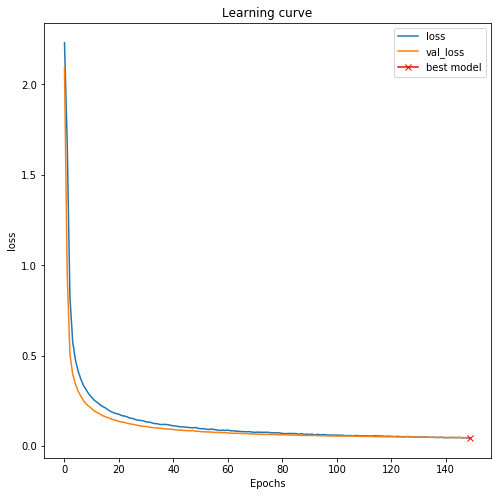

In [17]:
train_loss = hist.history['loss']
val_loss = hist.history['val_loss'] 
train_acc = hist.history['acc']
val_acc = hist.history['val_acc']

plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(hist.history["loss"], label="loss")
plt.plot(hist.history["val_loss"], label="val_loss")
plt.plot( np.argmin(hist.history["val_loss"]), np.min(hist.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.legend()

In [18]:
# Find test loss and accuracy
score = model.evaluate(X_test, Y_test, verbose=0) # accuracy check
print('Test loss:', score[0], 'Accuracy:', score[1]) 

Test loss: 0.05272779184038795 Accuracy: 0.9845238095238096


In [19]:
# Testing
test_data = np.genfromtxt('test.csv', delimiter = ',')
test_data = test_data[1:]

In [20]:
print(test_data)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [21]:
test_data = test_data.reshape(test_data.shape[0], img_rows, img_cols, 1) 
test_data = test_data.astype('float32')

test_data /= 255

In [22]:
predictions = model.predict_classes(test_data)
print(predictions)

[2 0 9 ... 3 9 2]


In [23]:
output=pd.DataFrame({"ImageId": list(range(1,len(predictions)+1)), "Label": predictions})
output.to_csv("submission.csv", index=False, header=True)